## 1. (c) We have provided a dataset from taxi trips taken in NYC in taxi trips.parquet. It contains 8 total columns, 7 features and 1 target (trip duration). De ne a multi-layer perceptron in PyTorch or Jax that outputs a conditional mean and variance, and  t this on the taxi trip dataset. Make sure to follow best practices: de ne a baseline (or multiple) baseline models that you think your model should beat, split your dataset into training/validation/test sets, etc.

In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import torch

In [2]:
# read parquet file as pandas dataframe
df = pq.read_table('taxi_trips.parquet').to_pandas()
df

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,min_of_day,day_of_week,day_of_year
187173,0.270744,1.425051,0.466831,0.776192,-0.007192,-0.942057,-1.047619,1.180855
179655,0.085681,0.306079,-0.226274,0.124111,0.370803,0.778703,-1.047619,-0.311290
120048,-0.555533,-0.934806,-0.022489,-0.548561,-0.434735,-1.183016,-1.047619,1.316504
62587,0.069718,0.035804,0.258900,0.317284,-0.811614,-0.908008,0.481657,0.018144
212063,-0.234482,0.074616,0.115836,0.258310,0.480548,1.066806,-0.537860,0.521985
...,...,...,...,...,...,...,...,...
519591,-0.853230,-0.623528,-1.257638,-0.858561,-0.496274,1.548723,0.991416,1.665317
342999,0.623131,0.373217,-0.558609,-0.119350,0.789244,-1.714696,0.481657,-1.745299
157477,-0.226796,-0.595202,-0.527212,-1.051594,0.081328,-1.976608,1.501174,0.056901
432901,-0.226796,0.056775,1.005321,-1.571717,1.210403,1.111331,-0.028101,0.812663


In [3]:
# define target
y = torch.tensor(df['trip_duration'].to_numpy())
y.shape

torch.Size([523554])

In [4]:
# define features
X = torch.tensor(df.drop(columns=['trip_duration']).to_numpy())
X.shape

torch.Size([523554, 7])

In [5]:
# split in training, test and validations
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10.0/80.0, random_state=1)

print('shapes:\n- - - -')
print(f'x_train: {X_train.shape}\t y_train: {y_train.shape}\t frac: {y_train.shape[0]/y.shape[0]*100:.2f}%')
print(f'x_test: {X_test.shape}\t\t y_test: {y_test.shape}\t frac: {y_test.shape[0]/y.shape[0]*100:.2f}%')
print(f'x_val: {X_val.shape}\t\t y_val: {y_val.shape}\t frac: {y_val.shape[0]/y.shape[0]*100:.2f}%')

shapes:
- - - -
x_train: torch.Size([366487, 7])	 y_train: torch.Size([366487])	 frac: 70.00%
x_test: torch.Size([104711, 7])		 y_test: torch.Size([104711])	 frac: 20.00%
x_val: torch.Size([52356, 7])		 y_val: torch.Size([52356])	 frac: 10.00%


In [6]:
# Baseline model: simple linear regression
from sklearn.linear_model import LinearRegression
# create linear model to predict y from X
model_baseline = LinearRegression().fit(X_train, y_train)
y_pred_baseline = torch.tensor(model_baseline.predict(X_test))

In [7]:
# Calculate r-squared score for baseline model
from torcheval.metrics.functional import r2_score
r2_score(y_pred_baseline, y_test)

tensor(0.0189)

In [8]:
# loss fn and NN model
import torch.nn as nn

class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, g_vec, y_true):
        f_mu = g_vec[:,0]
        f_sigma = torch.log(1+torch.exp(g_vec[:,1]))
        L = torch.log(f_sigma) + 1/2*(y_true-f_mu)**2/f_sigma**2
        return L.mean()

class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
        )

    def forward(self, x):
        g_vec = self.linear_relu_stack(x)
        return g_vec

In [9]:
def train_model():
    # define model
    model = NNModel()
    # define loss function
    loss_fn = MyLoss()
    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # train
    for t in range(1000):
        # Forward pass: compute predicted y by passing x to the model.
        g_vec = model(X_train)

        # Compute and print loss.
        loss = loss_fn(g_vec, y_train)
        if t % 100 == 99:
            print(t, loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

    return model

In [10]:
trained_model = train_model()

99 0.06182841584086418
199 -0.25600045919418335
299 -0.3149549663066864
399 -0.3442245125770569
499 -0.3615590035915375
599 -0.3732012212276459
699 -0.3820852041244507
799 -0.38364002108573914
899 -0.394769549369812
999 -0.4011291563510895


In [11]:
# Calculate the predicted values using the trained model
g_pred = trained_model(X_test)
y_pred = g_pred[:,0]
sigma_pred = torch.log(1+torch.exp(g_pred[:,1]))

# Calculate the R-squared score
r2_score(y_pred, y_test)

tensor(0.7508)

Since the NN had good R2 value from the beginning (0.7508) in comparison to the baseline linear fit (0.0534) on the test dataset, I won't be optimizing hyperparameters. The model performance is good enough for the purposes of this problem. 

## 1. (d) How would we use the model we've just got to predict the probability that a trip will take less than 45 minutes? The normal distribution assumption is fine.

First, we need to transform 45 minutes to the scaling the data used (I won't follow the suggestion on Canvas since scaling the model output to minutes will be easy for the mean but difficult for the variance since it involves a non-linear transformation. It is much easier to transform 45 minutes to the standarized units). We can then use the normal distribution CDF with mean $f_{\mu}(x)$ and std dev $f_{\sigma}(x)$ predicted by our model to get $P(y<45 min | X) $

## 1. (e) Estimate these probabilities on your held-out test set and report your accuracy.

In [24]:
t_45_minutes_scaled = (np.log(60.0*45.0) - 6.175) / 0.776
t_45_minutes_scaled

2.2242358917428096

In [34]:
from scipy.stats import norm
probs_t_less_than_45_minutes = norm.cdf(t_45_minutes_scaled, loc=y_pred.detach().numpy(), scale=sigma_pred.detach().numpy())
probs_t_less_than_45_minutes

array([1.        , 0.99999996, 1.        , ..., 1.        , 0.99999609,
       1.        ])

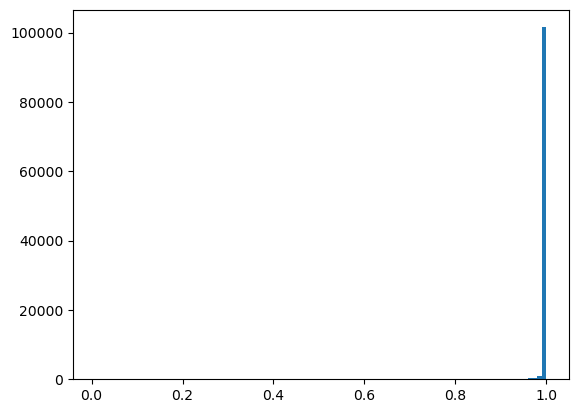

In [42]:
import matplotlib.pyplot as plt
plt.hist(probs_t_less_than_45_minutes, bins=100)
plt.show()

Note that I can not report an accuracy for the probabilities themselves, since we don't have a 'ground truth' probability nor distribution for the test set. We only have the actual trip durationvalues. What I could is assume that the features of the test set are evenly distributed across the feature domain and calculate the overall probability of the travel being less than 45 mins:

In [25]:
prob_less_than_45_test_set = (y_test < t_45_minutes_scaled).sum()/len(y_test)
prob_less_than_45_test_set

tensor(0.9954)

This is very close to 1, consistent with what we see in the histogram for the model probabilities. This means the model seems to be accurate ( to be honest, 45 min was just a very large number given the data and transformation that we got, so we expected this probability to be 1 from the beginning and this was not a very elaborate analysis.)